<a href="https://colab.research.google.com/github/whiletrueee/energy/blob/main/minor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
pip install opendatasets pandas numpy matplotlib seaborn folium --q

In [72]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import lightgbm as lgb
from sklearn.model_selection import KFold
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

od.download('https://www.kaggle.com/competitions/ashrae-energy-prediction/data')

Skipping, found downloaded files in "./ashrae-energy-prediction" (use force=True to force download)


In [73]:
data_dir = './ashrae-energy-prediction'
!head {data_dir}/weather_train.csv

site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,2016-01-01 00:00:00,25.0,6.0,20.0,,1019.7,0.0,0.0
0,2016-01-01 01:00:00,24.4,,21.1,-1.0,1020.2,70.0,1.5
0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6
0,2016-01-01 05:00:00,19.4,,19.4,0.0,,0.0,0.0
0,2016-01-01 06:00:00,21.1,6.0,21.1,-1.0,1019.4,0.0,0.0
0,2016-01-01 07:00:00,21.1,,21.1,0.0,1018.8,210.0,1.5
0,2016-01-01 08:00:00,20.6,,20.0,0.0,1018.1,0.0,0.0


In [74]:
%%time
import random

dtypes = {
    'building_id':'int16',
    'meter':'int8',
    'meter_reading':'float32'
}

def skip_row(row_idx):
    if row_idx == 0:
        return False
    return random.random() > sample_frac

random.seed(42)
train_df = pd.read_csv(data_dir+"/train.csv",
                 #usecols=selected_cols,
                 dtype=dtypes,
                 parse_dates=['timestamp'])
                 #skiprows=skip_row)

CPU times: user 13.8 s, sys: 924 ms, total: 14.8 s
Wall time: 26.3 s


In [75]:
train_df.sample(5)

,building_id,meter,timestamp,meter_reading
898741,1210,1,2016-01-17 07:00:00,1.666000
5077567,547,0,2016-04-06 07:00:00,33.889999
7302270,78,0,2016-05-15 21:00:00,0.000000
394091,929,0,2016-01-08 03:00:00,306.000000
10500050,106,0,2016-07-11 17:00:00,0.749200


In [76]:
building_dtypes={
    'site_id':'int8',
    'building_id':'int16',
    'square_feet':'int32',
    'year_built':'float16',
    'floor_count':'float16'}

weather_dtypes={
    'site_id':'int8',
    'air_temperature':'float16',
    'cloud_coverage':'float16',
    'dew_temperature':'float16',
    'precip_depth_1_hr':'float16',
    'sea_level_pressure':'float16',
    'wind_direction':'float16',
    'wind_speed':'float16',
}
weather_train_df=pd.read_csv('/content/ashrae-energy-prediction/weather_train.csv',dtype=weather_dtypes,parse_dates=['timestamp'])
weather_train_df.sample(5)

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
117852,13,2016-06-19 13:00:00,25.000000,4.0,16.093750,0.0,1018.0,200.0,4.101562
98424,11,2016-03-30 19:00:00,10.000000,NaN,-3.699219,NaN,1016.0,220.0,5.101562
85276,9,2016-09-25 19:00:00,27.796875,0.0,22.796875,0.0,1014.0,360.0,1.500000
51776,5,2016-11-25 16:00:00,8.000000,0.0,3.000000,NaN,NaN,60.0,5.699219
8464,0,2016-12-18 16:00:00,26.703125,NaN,22.203125,0.0,1023.0,190.0,4.601562


In [77]:
weather_test_df=pd.read_csv('/content/ashrae-energy-prediction/weather_test.csv',dtype=weather_dtypes,parse_dates=['timestamp'])

In [78]:
weather_train_df.sample(5)

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
28623,3,2016-04-05 13:00:00,0.600098,2.0,-10.601562,0.0,1028.0,360.0,12.898438
97790,11,2016-03-03 16:00:00,-15.796875,NaN,-23.000000,NaN,1028.0,240.0,4.101562
4094,0,2016-06-19 14:00:00,27.203125,4.0,23.296875,0.0,1020.0,50.0,5.101562
87917,10,2016-01-13 22:00:00,-3.900391,0.0,-6.699219,0.0,1018.0,310.0,3.599609
33442,3,2016-10-23 11:00:00,8.296875,2.0,1.700195,0.0,1016.5,200.0,5.101562


In [79]:
test_df=pd.read_csv('/content/ashrae-energy-prediction/test.csv',dtype=dtypes,parse_dates=['timestamp'])
test_df.sample(5)

,row_id,building_id,meter,timestamp
32489252,32489252,1229,1,2017-02-18 14:00:00
27434570,27434570,1174,0,2017-04-04 14:00:00
32412919,32412919,1225,0,2017-02-07 13:00:00
21924324,21924324,874,0,2017-11-05 03:00:00
28210096,28210096,1146,1,2017-07-18 04:00:00


In [80]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    int16         
 1   meter          int8          
 2   timestamp      datetime64[ns]
 3   meter_reading  float32       
dtypes: datetime64[ns](1), float32(1), int16(1), int8(1)
memory usage: 289.2 MB


In [81]:
train_df.describe()

,building_id,meter,meter_reading
count,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,2.117122e+03
std,4.269133e+02,9.309921e-01,1.532356e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01
50%,8.950000e+02,0.000000e+00,7.877500e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02
max,1.448000e+03,3.000000e+00,2.190470e+07


In [82]:
train_df.timestamp.min(),train_df.timestamp.max()

(Timestamp('2016-01-01 00:00:00'), Timestamp('2016-12-31 23:00:00'))

In [83]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (8, 4)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

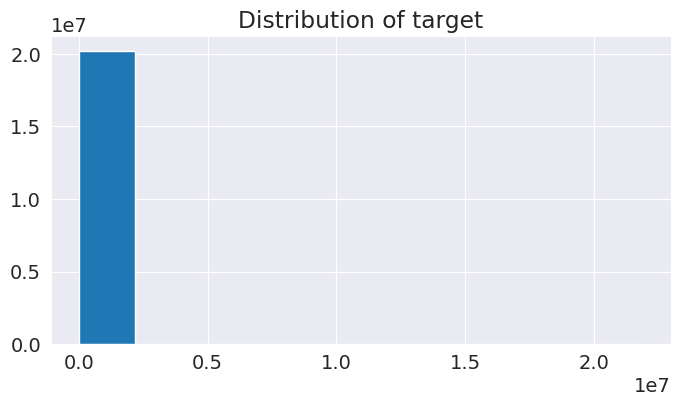

In [84]:
plt.hist(train_df['meter_reading']);
plt.title('Distribution of target');

In [85]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 4 columns):
 #   Column       Dtype         
---  ------       -----         
 0   row_id       int64         
 1   building_id  int16         
 2   meter        int8          
 3   timestamp    datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int64(1), int8(1)
memory usage: 755.6 MB


In [86]:
test_df.describe()

,row_id,building_id,meter
count,4.169760e+07,4.169760e+07,4.169760e+07
mean,2.084880e+07,8.075824e+02,6.642857e-01
std,1.203706e+07,4.297680e+02,9.278067e-01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.042440e+07,4.047500e+02,0.000000e+00
50%,2.084880e+07,9.000000e+02,0.000000e+00
75%,3.127320e+07,1.194250e+03,1.000000e+00
max,4.169760e+07,1.448000e+03,3.000000e+00


In [87]:
test_df.timestamp.min(),test_df.timestamp.max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2018-12-31 23:00:00'))

In [88]:
weather_train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             139773 non-null  int8          
 1   timestamp           139773 non-null  datetime64[ns]
 2   air_temperature     139718 non-null  float16       
 3   cloud_coverage      70600 non-null   float16       
 4   dew_temperature     139660 non-null  float16       
 5   precip_depth_1_hr   89484 non-null   float16       
 6   sea_level_pressure  129155 non-null  float16       
 7   wind_direction      133505 non-null  float16       
 8   wind_speed          139469 non-null  float16       
dtypes: datetime64[ns](1), float16(7), int8(1)
memory usage: 3.1 MB


In [89]:
weather_train_df.describe()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,139773.000000,139718.000000,70600.0,139660.000000,89484.0,129155.0,133505.0,139469.000000
mean,7.478977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.604744,0.000000,0.0,0.000000,NaN,NaN,NaN,0.000000
min,0.000000,-28.906250,0.0,-35.000000,-1.0,968.0,0.0,0.000000
25%,3.000000,7.199219,0.0,0.600098,0.0,1012.0,80.0,2.099609
50%,7.000000,15.000000,2.0,8.296875,0.0,1016.5,190.0,3.099609
75%,11.000000,22.203125,4.0,14.398438,0.0,1021.0,280.0,5.000000
max,15.000000,47.187500,9.0,26.093750,343.0,1046.0,360.0,19.000000


In [ ]:
train_df.isna().sum()/len(train_df)

building_id      0.0
meter            0.0
timestamp        0.0
meter_reading    0.0
dtype: float64

In [ ]:
train_df.isna().sum()/len(train_df)

building_id      0.0
meter            0.0
timestamp        0.0
meter_reading    0.0
dtype: float64

In [ ]:
weather_train_df.isna().sum()/len(weather_train_df)

site_id               0.000000
timestamp             0.000000
air_temperature       0.000393
cloud_coverage        0.494895
dew_temperature       0.000808
precip_depth_1_hr     0.359791
sea_level_pressure    0.075966
wind_direction        0.044844
wind_speed            0.002175
dtype: float64

In [94]:
def fill_missing(df):
  for i in df.columns:
    if df[i].isna().sum()!=0:
      if df[i].dtype == 'float16':
        df[i]=df[i].astype('float32')
      if df[i][0]==np.nan:
        df[i][0]=df[i].mean()
      df[i].fillna(method='ffill',inplace=True)
  return df

In [95]:
weather_train_df=fill_missing(weather_train_df)

In [96]:
weather_test_df=fill_missing(weather_test_df)

In [97]:
building_dtypes={
    'site_id':'int8',
    'building_id':'int16',
    'square_feet':'int32',
    'year_built':'float16',
    'floor_count':'float16'}

In [98]:
building_df=pd.read_csv('/content/ashrae-energy-prediction/building_metadata.csv',dtype=building_dtypes)
building_df.sample(5)

,site_id,building_id,primary_use,square_feet,year_built,floor_count
653,4,653,Education,420885,1930.0,8.0
368,3,368,Retail,16500,NaN,NaN
1127,13,1127,Office,87131,NaN,NaN
666,5,666,Entertainment/public assembly,12045,1976.0,1.0
169,2,169,Education,179559,2006.0,NaN


In [99]:
building_df.isna().sum()/len(building_df)

site_id        0.000000
building_id    0.000000
primary_use    0.000000
square_feet    0.000000
year_built     0.534161
floor_count    0.755003
dtype: float64

In [100]:
building_df.drop(columns=['year_built','floor_count'],inplace=True)

In [101]:
temp_df=weather_train_df[['site_id','timestamp','air_temperature']]
temp_df['temp_rank']=temp_df.groupby(['site_id', temp_df.timestamp.dt.date],)['air_temperature'].rank('average')
df_2d=temp_df.groupby(['site_id', temp_df.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)

<ipython-input-101-1bbb1263ca8d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['temp_rank']=temp_df.groupby(['site_id', temp_df.timestamp.dt.date],)['air_temperature'].rank('average')


Text(0.5, 1.0, 'Mean temperature rank by hour (aligned timestamps)')

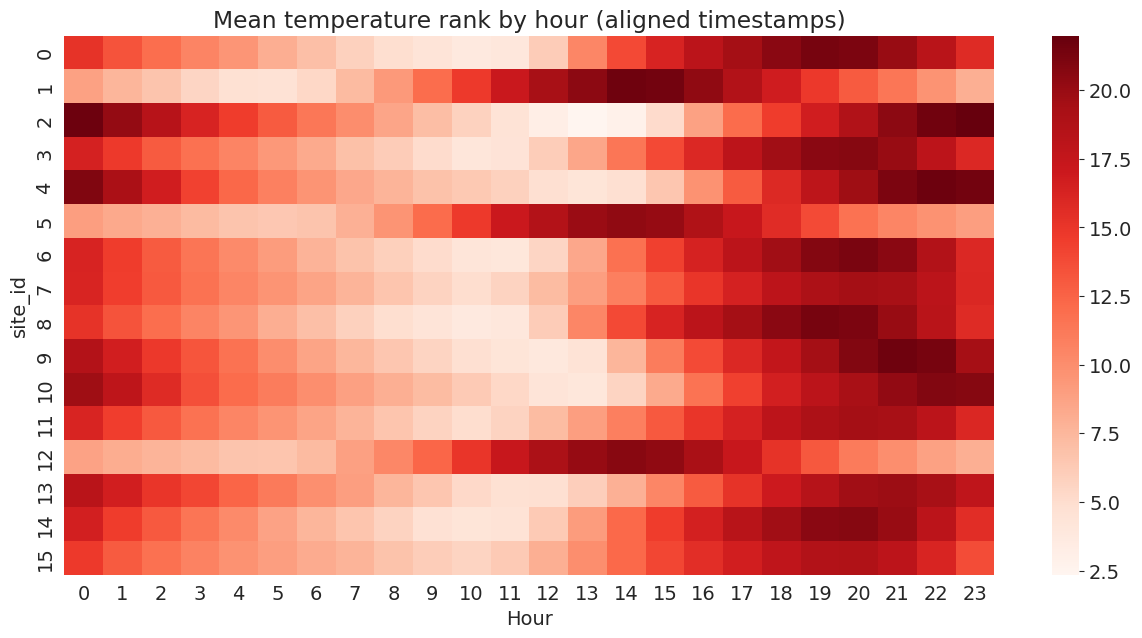

In [102]:
plt.figure(figsize=(15, 7))
sns.heatmap(df_2d,cmap='Reds');
plt.xlabel('Hour')
plt.title('Mean temperature rank by hour (aligned timestamps)')

In [103]:
def time_alignment(df):
  temp_df=df[['site_id','timestamp','air_temperature']]
  temp_df['temp_rank']=temp_df.groupby(['site_id', temp_df.timestamp.dt.date],)['air_temperature'].rank('average')
  df_2d=temp_df.groupby(['site_id', temp_df.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)
  df_2d = df_2d / df_2d.max(axis=1).values.reshape((-1,1))
  site_ids_argmax_maxtemp=pd.Series(np.argmax(df_2d.values,axis=1)).sort_values().index
  site_ids_offsets= pd.Series(df_2d.values.argmax(axis=1) - 14)
  df_2d=df_2d.iloc[site_ids_argmax_maxtemp]
  temp_df['offset'] = temp_df.site_id.map(site_ids_offsets)
  temp_df['timestamp_aligned'] = (temp_df.timestamp - pd.to_timedelta(temp_df.offset, unit='H'))
  df['timestamp']=temp_df['timestamp_aligned']
  return df

In [104]:
weather_train_df=time_alignment(weather_train_df)
weather_test_df=time_alignment(weather_test_df)

<ipython-input-103-7af9ac244a05>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['temp_rank']=temp_df.groupby(['site_id', temp_df.timestamp.dt.date],)['air_temperature'].rank('average')
<ipython-input-103-7af9ac244a05>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['offset'] = temp_df.site_id.map(site_ids_offsets)
<ipython-input-103-7af9ac244a05>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [105]:
temp_df=weather_train_df[['site_id','timestamp','air_temperature']]
temp_df['temp_rank']=temp_df.groupby(['site_id', temp_df.timestamp.dt.date],)['air_temperature'].rank('average')
df_2d=temp_df.groupby(['site_id', temp_df.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)


<ipython-input-105-1bbb1263ca8d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['temp_rank']=temp_df.groupby(['site_id', temp_df.timestamp.dt.date],)['air_temperature'].rank('average')


Text(0.5, 1.0, 'Mean temperature rank by hour (aligned timestamps)')

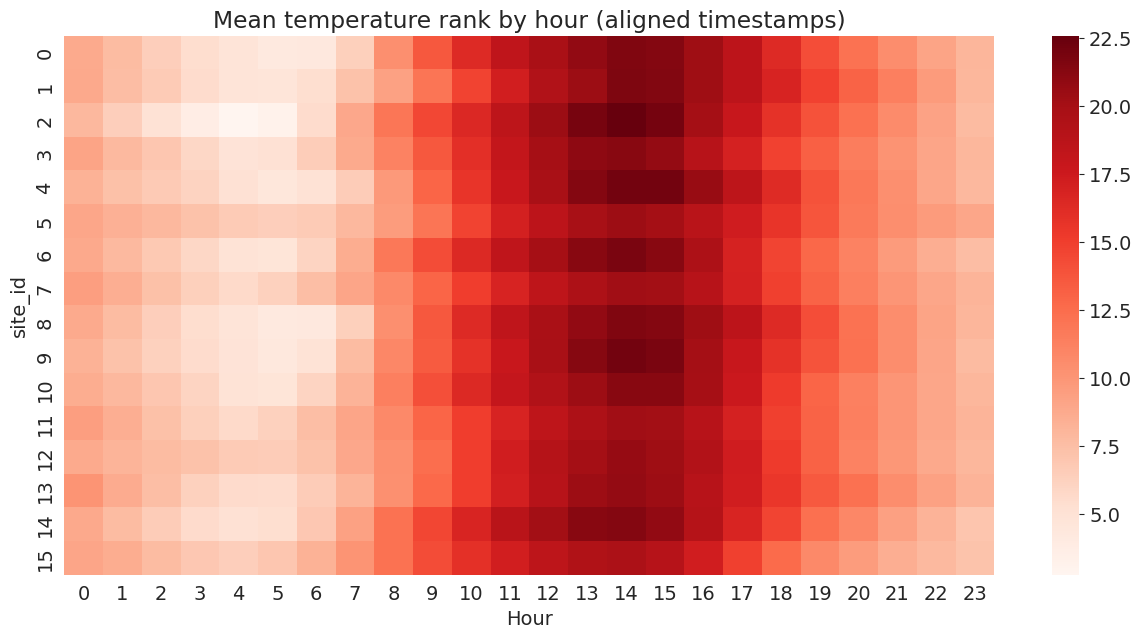

In [106]:
plt.figure(figsize=(15, 7))
sns.heatmap(df_2d,cmap='Reds');
plt.xlabel('Hour')
plt.title('Mean temperature rank by hour (aligned timestamps)')

In [107]:
from sklearn.preprocessing import LabelEncoder


In [108]:
building_df=pd.read_csv('/content/ashrae-energy-prediction/building_metadata.csv',dtype=building_dtypes)

In [110]:
building_df.drop(columns=['year_built','floor_count'],inplace=True)

In [111]:
# Encode categorical column primary use
le = LabelEncoder()
building_df["primary_use"] = le.fit_transform(building_df["primary_use"])

In [112]:
building_df['primary_use']=building_df['primary_use'].astype('int8')

In [113]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    int16         
 1   meter          int8          
 2   timestamp      datetime64[ns]
 3   meter_reading  float32       
dtypes: datetime64[ns](1), float32(1), int16(1), int8(1)
memory usage: 289.2 MB


In [114]:
#merge training data with building and weather data
train_build_df=train_df.merge(building_df,on='building_id',how='left')
train_merge_df=train_build_df.merge(weather_train_df,how='left',left_on=['site_id','timestamp'],right_on=['site_id','timestamp'])
del weather_train_df, train_df,train_build_df

In [115]:
train_merge_df.isna().sum()

building_id                0
meter                      0
timestamp                  0
meter_reading              0
site_id                    0
primary_use                0
square_feet                0
air_temperature       103451
cloud_coverage        103451
dew_temperature       103451
precip_depth_1_hr     103451
sea_level_pressure    103451
wind_direction        103451
wind_speed            103451
dtype: int64

In [116]:
def fill_missing(df):
  for i in df.columns:
    if df[i].isna().sum()!=0:
      if df[i].dtype == 'float16':
        df[i]=df[i].astype('float32')
      if df[i][0]==np.nan:
        df[i][0]=df[i].mean()
      df[i].fillna(method='ffill',inplace=True)
  return df

In [117]:
train_merge_df=fill_missing(train_merge_df)

In [118]:
train_merge_df.isna().sum()

building_id           0
meter                 0
timestamp             0
meter_reading         0
site_id               0
primary_use           0
square_feet           0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

In [119]:
# site 0 meter reading is given in KBTU, hence convert them to kwh
train_merge_df.loc[train_merge_df[train_merge_df['site_id']==0].index,'meter_reading']=train_merge_df[train_merge_df['site_id']==0]['meter_reading']*0.2931

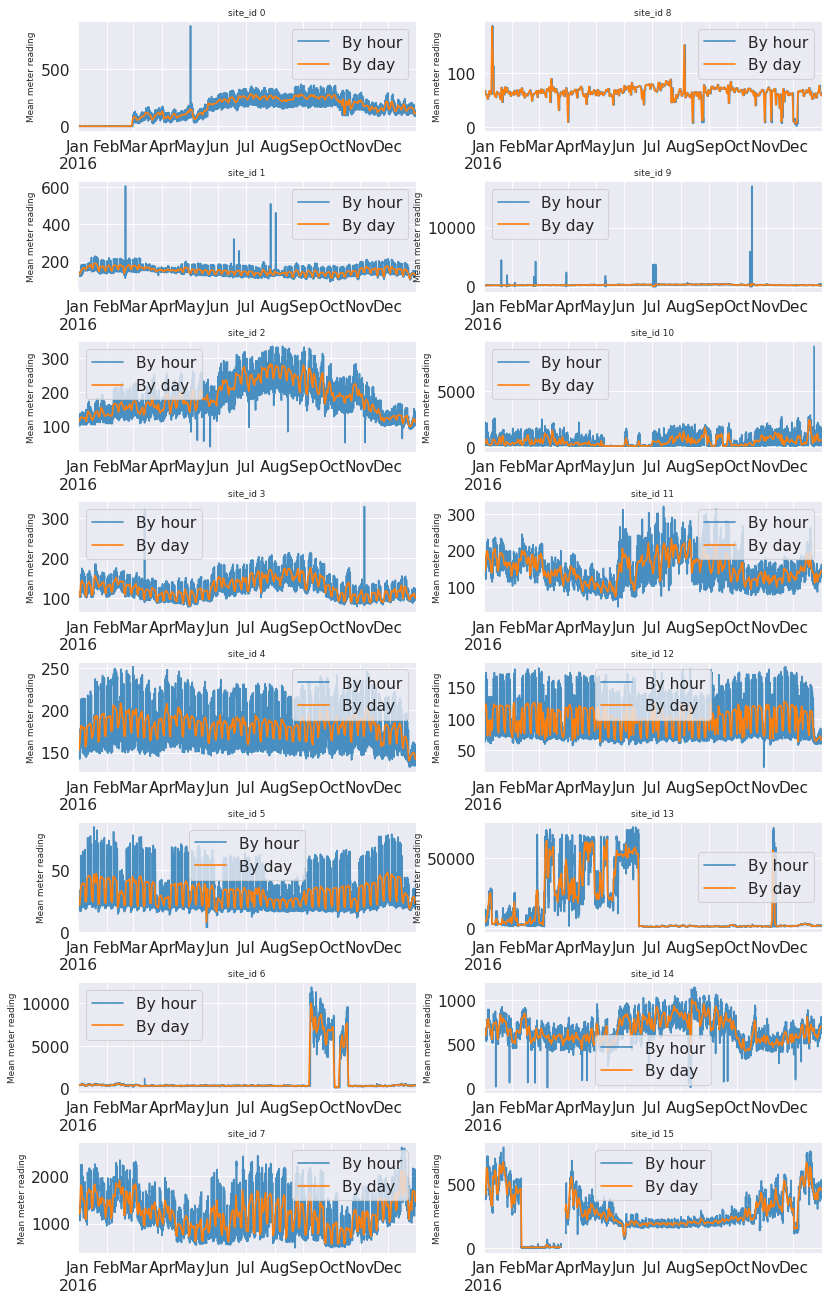

In [120]:
fig, axes = plt.subplots(8,2,figsize=(12, 20), dpi=80)
plt.xticks(rotation=75)
for i in range(train_merge_df['site_id'].nunique()):
    train_merge_df[train_merge_df['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=8);
    train_merge_df[train_merge_df['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange').set_xlabel('');
    axes[i%8][i//8].legend();
    axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize=8);
    plt.subplots_adjust(hspace=0.45)

In [121]:
train_merge_df=train_merge_df[train_merge_df['meter_reading']!=0]
train_merge_df = train_merge_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

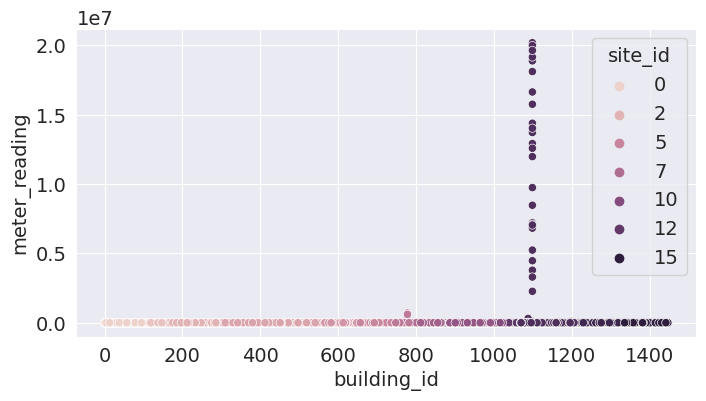

In [122]:
train_sample=train_merge_df.sample(202161)
sns.scatterplot(x=train_sample.building_id,y=train_sample.meter_reading,hue=train_sample.site_id);
del train_sample

In [123]:
train_merge_df.sort_values('meter_reading',ascending=False).head(5)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
8907488,1099,2,2016-06-13 09:00:00,21904700.0,13,0,332884,24.406250,4.0,17.203125,0.0,1013.0,210.0,2.099609
8738539,1099,2,2016-06-10 09:00:00,21889900.0,13,0,332884,30.000000,4.0,19.406250,0.0,1007.0,210.0,4.601562
8736187,1099,2,2016-06-10 08:00:00,21874500.0,13,0,332884,28.296875,4.0,18.906250,0.0,1007.5,230.0,4.601562
17286421,1099,2,2016-11-09 14:00:00,21847900.0,13,0,332884,15.000000,2.0,1.700195,0.0,1023.5,230.0,4.601562
8905140,1099,2,2016-06-13 08:00:00,21844500.0,13,0,332884,22.796875,4.0,16.703125,0.0,1013.5,160.0,4.601562


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import shutil

# Move the file to Google Drive
shutil.copy("/content/file1.csv", "/content/drive/MyDrive/")


'/content/drive/MyDrive/file1.csv'

In [ ]:
train_merge_df.to_csv('file1.csv')

In [124]:
train_merge_df = train_merge_df [ train_merge_df['building_id'] != 1099 ]

In [125]:
def breakdown_timestamp(dataframe):
   dataframe['hour']= np.uint8(dataframe['timestamp'].dt.hour)
   dataframe['day']= np.uint8(dataframe['timestamp'].dt.day)
   dataframe['weekday']= np.uint8(dataframe['timestamp'].dt.weekday)
   dataframe['month']= np.uint8(dataframe['timestamp'].dt.month)
   #dataframe['year']= np.uint16(dataframe['timestamp'].dt.year)
   dataframe.drop(['timestamp'],axis=1,inplace=True)
   return dataframe

In [126]:
train_merge_df=breakdown_timestamp(train_merge_df)

In [127]:
# take logarthmic value of meter reading
train_merge_df['meter_reading']=np.log1p(train_merge_df["meter_reading"])

In [128]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (8, 4)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

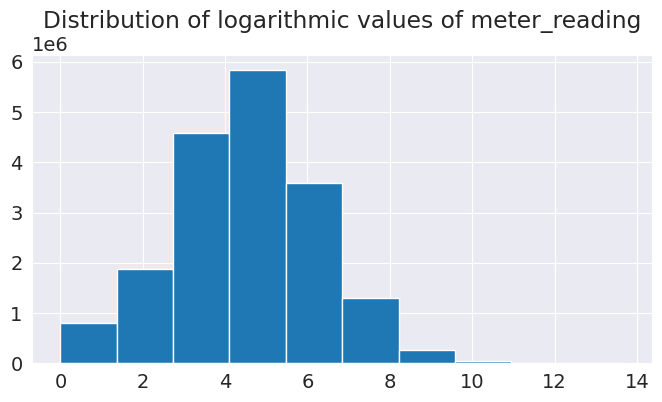

In [129]:
plt.hist(train_merge_df['meter_reading']);
plt.title('Distribution of logarithmic values of meter_reading');

In [130]:
input_columns=['building_id', 'site_id','primary_use', 'square_feet', 'air_temperature', 'cloud_coverage','dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction','wind_speed', 'hour', 'day','weekday', 'month']

output_columns='meter_reading'

In [131]:
from sklearn.model_selection import train_test_split

trainset_df,validset_df =  train_test_split(train_merge_df,
                                    test_size=0.4,
                                    random_state=42)

In [132]:
test_df=test_df.merge(building_df,on='building_id',how='left')
test_df=test_df.merge(weather_test_df,how='left',left_on=['site_id','timestamp'],right_on=['site_id','timestamp'])
del building_df
del weather_test_df

In [133]:
test_df=fill_missing(test_df)

In [134]:
test_df=breakdown_timestamp(test_df)

In [135]:
from sklearn.linear_model import LinearRegression
linreg_model = LinearRegression()
linreg_model.fit(trainset_df[input_columns], trainset_df[output_columns])

LinearRegression()

In [ ]:
train_rmse = mean_squared_error(trainset_df[output_columns], linreg_model.predict(trainset_df[input_columns]), squared=False)
train_rmse

1.4565257796986395

In [ ]:
val_rmse = mean_squared_error(validset_df[output_columns],linreg_model.predict(validset_df[input_columns]), squared=False)
val_rmse

1.4565425080502876

In [137]:
elcprediction = linreg_model.predict(trainset_df[input_columns])

In [141]:
print(elcprediction)

[3.82956144 4.7581731  3.97276715 ... 3.09691658 4.67880256 5.65851576]


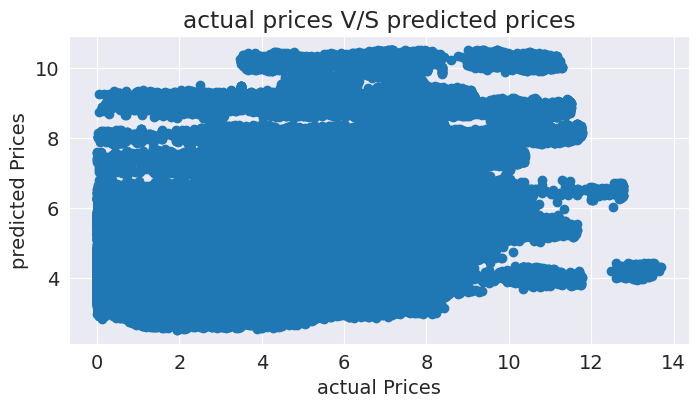

In [142]:
plt.scatter(trainset_df[output_columns], elcprediction)
plt.xlabel("actual Prices")
plt.ylabel("predicted Prices")
plt.title("actual prices V/S predicted prices")
plt.show()

In [143]:
score_1 = metrics.r2_score(elcprediction, trainset_df[output_columns])
print(100 - score_1)

#Mean absolute error
score_2 = metrics.mean_absolute_error(elcprediction, trainset_df[output_columns])
print(score_2)

101.2607887390362
1.114298999422538


In [ ]:
dec_model = DecisionTreeRegressor(random_state=33)
dec_model.fit(trainset_df[input_columns], trainset_df[output_columns])
train_rmse =  mean_squared_error(trainset_df[output_columns], dec_model.predict(trainset_df[input_columns]), squared=False)
val_rmse =  mean_squared_error(validset_df[output_columns], dec_model.predict(validset_df[input_columns]), squared=False)
print('train_rmse is {}, val_rmse is {}'.format(train_rmse, val_rmse))

train_rmse is 0.7057570739189486, val_rmse is 1.4026827748681256


In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold

def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model_lgbm = LGBMRegressor(random_state=33, n_jobs=-1, **params)
    model_lgbm.fit(X_train, train_targets)
    train_rmse = mean_squared_error(train_targets, model_lgbm.predict(X_train), squared=False)
    val_rmse = mean_squared_error(val_targets, model_lgbm.predict(X_val), squared=False)
    return model_lgbm, train_rmse, val_rmse

kfold = KFold(n_splits=3)


def train_kfold(train_df, target_meter):
  models=[]
  train_meter_df=train_df[train_df['meter']==target_meter]
  for train_idxs, val_idxs in kfold.split(train_meter_df[input_columns]):
    X_train, train_targets = train_meter_df[input_columns].iloc[train_idxs], train_meter_df[output_columns].iloc[train_idxs]
    X_val, val_targets = train_meter_df[input_columns].iloc[val_idxs], train_meter_df[output_columns].iloc[val_idxs]
    model_lgbm, train_rmse, val_rmse = train_and_evaluate(X_train,
                                                     train_targets,
                                                     X_val,
                                                     val_targets)
    models.append(model_lgbm)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))
  del train_meter_df
  return models

In [ ]:
import numpy as np

def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [ ]:
models0=train_kfold(train_merge_df,0)
models1=train_kfold(train_merge_df,1)
models2=train_kfold(train_merge_df,2)
models3=train_kfold(train_merge_df,3)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.398925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1327
[LightGBM] [Info] Number of data points in the train set: 7679061, number of used features: 15
[LightGBM] [Info] Start training from score 4.105478
Train RMSE: 0.593909807760798, Validation RMSE: 0.6156338133343808
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.402765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 7679061, number of used features: 15
[LightGBM] [Info] Start training from score 4.089911
Train RMSE: 0.577999110340234, Validation RMSE: 0.6267717446496599
[LightGBM] [Info] Auto-choosing row-wise multi-thr

In [ ]:
test0_preds=predict_avg(models0,test_df[test_df['meter']==0][input_columns])

NameError: ignored

In [ ]:
import numpy as np

def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [ ]:
test1_preds=predict_avg(models1,test_df[test_df['meter']==1][input_columns])
test2_preds=predict_avg(models2,test_df[test_df['meter']==2][input_columns])
test3_preds=predict_avg(models3,test_df[test_df['meter']==3][input_columns])

NameError: ignored